# Prediction visualisation (this notebook)

* this notebook uses Biopython to process mmCIF files
* this notebook can handle proteins of arbitrary length
* colouring scheme:
  1. non-solenoid = grey
  2. beta-solenoid = magenta
  3. alpha/beta-solenoid = cyan
  4. alpha-solenoid = orange/gold


This notebook:  
1. Takes an input PDB ID and chain ID.
2. Processes the structure specified by point **1** to a distance matrix.
3. Loads and uses a given model to make predictions based on the distance matrix from point **2**.
4. Processes the predictions from point **3** and visualises them using the NglView and bokeh packages according to the colouring scheme outlined above.
5. Allows for user-defined repeat selection and output using the visualisation from point **4**.
6. Includes additional code for visualising user-defined repeat alignment outputs from mTM-Align.
---

# Imports

In [3]:
import math
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model, Model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Average
import tensorflow as tf
from Bio.PDB import *
from math import ceil
from typing import Callable, Union
from tensorflow.keras import backend as K
#https://dmnfarrell.github.io/bioinformatics/bokeh-sequence-aligner
import os, io, random
import string

from Bio.Seq import Seq
from Bio.Align import MultipleSeqAlignment
from Bio import AlignIO, SeqIO

import panel as pn
import panel.widgets as pnw
pn.extension()

from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, Plot, Grid, Range1d
from bokeh.models.glyphs import Text, Rect
from bokeh.layouts import gridplot
from bokeh.models.tools import SaveTool

from bokeh.io import show
from ipywidgets import Layout, Button, VBox, Label, Box, HBox
from matplotlib import cm, colors
import ipywidgets as widgets
from ipywidgets import interact, interact_manual,interactive
import nglview as nv
import re
import os

# Classes and Functions

## For prediction 

In [4]:
class Matrix:
    
    def __init__(self, coords, indices):
        self.coords=coords
        self.indices=indices-indices[0]
        
    #Generates a distance matrix
    # It takes three arguments: 
    #l - list of indices, 
    #m - list of atom coordinates, 
    #n - max x-dimension value of the matrix
    #It creates an array of zeros of appropriate dimensions and subsequently populates it with distance values.


        
    def make_matrix(self):

        matrix = np.zeros((self.indices[-1]+1, self.indices[-1]+1), np.float)
        for  x in range(0,len(self.coords)):
            for y in range(0, len(self.coords)):
                matrix[self.indices[x], self.indices[y]] = np.linalg.norm(self.coords[x]-self.coords[y])
        #matrix=np.reshape(matrix, (len(matrix),maxdim,1))
        #matrix=matrix.astype('float32')

        #plt.matshow(matrix)
        return matrix


In [5]:
class Protein:
    
    def __init__(self, path, chain,filetype):
        self.path = path
        self.chain = chain
        self.filetype=filetype
    #global - structure and pdb id
    def set_structure(self):
        if self.filetype=='cif':
            parser = MMCIFParser()
        elif self.filetype=='pdb':
            parser=PDBParser()
        structure=parser.get_structure("sds",self.path)
        self.structure=structure
        #self.pdb_id=self.structure.name

    #more local - chains, chain_ids and first residues
    def set_chains(self):
        self.chain_ids=[x.get_id() for x in self.structure[0]]
        self.first_res=self.structure[0][self.chain].get_unpacked_list()[0].get_id()[1]
        print(self.first_res)
             
    def __str__(self):
        
        return ("Protein_ID " + str(self.pdb_id) + " with chains " + str(self.chain_ids))
    
    #obtain arrays of atom coordinates and indices based on specified atom type
    def set_atom_lists(self,atom):
        
        self.coords=np.asarray([residue[str(atom)].get_coord() 
                                            for residue in self.structure[0][self.chain] if len(residue)>=4 and str(atom) in residue])
   
        self.indices=np.asarray([residue.get_id()[1] for residue in self.structure[0][self.chain] if len(residue)>=4 and str(atom) in residue])
        
        self.seq_ids=np.asarray([three_to_one_letter_dict[residue.get_resname()] for residue in self.structure[0][self.chain] if len(residue)>=4 and str(atom) in residue and residue.get_resname() in accepted_residues])
    def set_matrices(self):
        
        distance_matrix1=Matrix(self.coords, self.indices)
        self.atom_matrices=distance_matrix1.make_matrix()
    def output_matrices(self, path2):
        
        [np.savetxt(str(path2) + "/dmca_matrix_" + str(self.pdb_id) + "_" + str(self.chain_ids[i]) + "_clean_gemmi.csv", self.atom_matrices.get_matrix()[i], delimiter=',') for i in range(len(self.chain_ids))]

    def set_up(self):
        self.set_structure()
        self.set_chains()
        self.set_atom_lists('CA')
        self.set_matrices()

    def return_matrix_and_first_res(self):
        first_res_chain=self.first_res
        distance_matrix_chain=self.atom_matrices

        return first_res_chain, distance_matrix_chain, self.chain_ids


In [22]:
class Prediction:

    __slots__=['first_res_chain','distance_matrix_chain','loaded_model','sub_matrix_size','threshold','alpha_predictions','alphabeta_predictions','beta_predictions','maxlength','pad_value']

    def __init__(self, first_res_chain, distance_matrix_chain,loaded_model,sub_matrix_size, threshold,maxlength):
        self.first_res_chain = first_res_chain
        self.distance_matrix_chain=distance_matrix_chain
        self.loaded_model=loaded_model
        self.sub_matrix_size=sub_matrix_size
        self.threshold=threshold
        self.alpha_predictions=[]
        self.alphabeta_predictions=[]
        self.beta_predictions=[]
        self.maxlength=maxlength

    def process_matrix_for_prediction(self):

        def diagonal_split(matrix,sub_matrix_size):
            half_sub_matrix=int(sub_matrix_size/2)
            slices=[]
            for i in range(0,len(matrix)-half_sub_matrix,half_sub_matrix):
                slices.append(matrix[i:i+sub_matrix_size,i:i+sub_matrix_size])
            return np.asarray(slices)

        # obtain value to pad with
        dm_div = len(self.distance_matrix_chain)/self.sub_matrix_size
        if dm_div<1:
            pad_value=int(self.sub_matrix_size-len(self.distance_matrix_chain))+64
        else:
            pad_value = int(((ceil(dm_div) - dm_div)*self.sub_matrix_size))
        pad_value = int(((ceil(dm_div) - dm_div)*self.sub_matrix_size))
        half_pad=int(pad_value/2)
        lpad=half_pad+int(self.sub_matrix_size/4)
        rpad=pad_value-half_pad+int(self.sub_matrix_size/4)
        print(lpad)
        # pad distance matrix
        distance_matrix_padded = np.pad(self.distance_matrix_chain, ((lpad, rpad), (lpad, rpad)), 'constant', constant_values=(0, 0))

        #normalise distance matrix btw 0 and 1

        distance_matrix_padded=distance_matrix_padded/np.max(distance_matrix_padded)

        # split up distance matrix into 32x32 squares
        distance_matrix_reshaped = diagonal_split(distance_matrix_padded, self.sub_matrix_size)
        distance_matrix_reshaped=np.expand_dims(distance_matrix_reshaped,axis=-1)
        self.pad_value=lpad-int(self.sub_matrix_size/4)
        print("PADVALUE",self.pad_value)
        return distance_matrix_reshaped

    def make_prediction(self):
        distance_matrix_reshaped=self.process_matrix_for_prediction()
        total_predictions=np.array([])

        predictions=self.loaded_model.predict(distance_matrix_reshaped)
        #predictions=predictions>self.threshold

        predictions_argmaxed=np.argmax(predictions, axis=3)
        #predictions_argmaxed=predictions
        print(predictions.shape)
        prediction_matrix=np.zeros((predictions_argmaxed.shape[0]*64,predictions_argmaxed.shape[0]*64))
        print(prediction_matrix.shape)
        for i in range(predictions_argmaxed.shape[0]):
            prediction_matrix[i*64:i*64+64,i*64:i*64+64]=predictions_argmaxed[i]
        plt.matshow(prediction_matrix)
        return prediction_matrix

    def get_final_onehot(self):
        distance_matrix_reshaped=self.process_matrix_for_prediction()
        total_predictions=np.array([])

        predictions=self.loaded_model.predict(distance_matrix_reshaped)
        prediction_matrix=np.zeros((predictions.shape[0]*64,predictions.shape[0]*64,6))

        for i in range(predictions.shape[0]):
            prediction_matrix[i*64:i*64+64,i*64:i*64+64]=predictions[i]
        
        one_hot_preds=[]
        for i in range(self.pad_value-int(self.sub_matrix_size/4),len(prediction_matrix)):
            for j in range(self.pad_value-int(self.sub_matrix_size/4),len(prediction_matrix)):
                if i==j and i<=maxlength+self.pad_value-int(self.sub_matrix_size/4) and j<=maxlength+self.pad_value-int(self.sub_matrix_size/4):
                    one_hot_preds.append(prediction_matrix[i,j])
        
        return np.mean(one_hot_preds,axis=0)
        

    def get_solenoid_predictions(self):
        prediction_matrix=self.make_prediction()
        solenoid_list=[]
        beta_list=[]
        alphabeta_list=[]
        alpha_list=[]
        print(self.pad_value)
        for i in range(self.pad_value,len(prediction_matrix)):
            for j in range(self.pad_value,len(prediction_matrix)):
                if i==j and i <=self.maxlength+self.pad_value:
                    if prediction_matrix[i,j]==1:
                        beta_list.append(i+self.first_res_chain-self.pad_value)
                    elif prediction_matrix[i,j]==2:
                        alphabeta_list.append(i+self.first_res_chain-self.pad_value)
                    elif prediction_matrix[i,j]==3:
                        alpha_list.append(i+self.first_res_chain-self.pad_value)

        return np.unique(beta_list), np.unique(alphabeta_list), np.unique(alpha_list)

## For visualisation

In [6]:
def get_alignment(sequence):
    
    """
    
    Makes and outputs an 'alignment' using the sequence information in a pdb file.
    
     Parameters
    ----------
    structure_path : string
        Path to pdb file to visualise.
    x : string
        id of the protein.
        
     Returns
    ------
    A list of tuples containing indices for lines of protein sequence and the corresponding lines of protein sequence.

    """
    
    
    #https://stackoverflow.com/questions/10851445/splitting-a-string-by-list-of-indices
    #for record in SeqIO.parse(structure_path, "cif-seqres"):
        #if record.annotations['chain']==chain_id:

            #sequence=record.seq
    indices = np.arange(0,len(str(sequence)),50).tolist()
    parts = [str(sequence)[i:j] for i,j in zip(indices, indices[1:]+[None])]
    lines=[]
    line_indices=[]
    for line in parts:
        line_indices.append(f"{parts.index(line)*50+protein1.indices[0]}-{parts.index(line)*50+protein1.indices[0]+len(line)}")
        if len(line)==50:
            lines.append(line)
        else:
            lines.append(line + (50-len(line))*"-")

    return list(zip(line_indices,lines))

In [7]:
#ADAPTED FROM
#https://dmnfarrell.github.io/bioinformatics/bokeh-sequence-aligner

def get_colors(seqs,detected_list):
    """
    Makes colors for residues in the sequence by solenoid class.
    
    Parameters
    ----------
    detected_list : list
        List of indices of alpha,beta and alphabeta solenoid residue predictions.
        
    seqs: list
        List of 50-residue stretches of sequence.
        
    Returns
    ------
    
    An array containing color values for each residue in the sequence.
    
    
    """
    
    text = [i for s in list(seqs) for i in s]
    colors=[]
    for i in range(len(text)):
        if i+first_residue in detected_list[0]:
            colors.append('magenta')
        elif i+first_residue in detected_list[1]:
            colors.append('cyan')
        elif i+first_residue in detected_list[2]:
            colors.append('orange')
        
        #elif i+first_residue in detected_list[3]:
         #   colors.append('blue')
        #elif i+first_residue in detected_list[4]:
        #    colors.append('red')

        else:
            colors.append('grey')
    colors_A = np.asanyarray(colors).reshape(int(len(colors)/50),50)
    B=np.flipud(colors_A)

    return B.reshape(len(colors),)

In [8]:
#ADAPTED FROM
#https://dmnfarrell.github.io/bioinformatics/bokeh-sequence-aligner

def view_alignment(aln, detected_list,fontsize="9pt", plot_width=800):
    """Bokeh sequence alignment view"""

    #make sequence and id lists from the aln object
    seqs=[i[1] for i in aln]
    ids=[i[0] for i in aln]
    #seqs = [rec.seq for rec in (aln)]
    #ids = [rec.id for rec in aln]
    #text = [i for s in list(seqs) for i in s]
    seqs.reverse()
    text = [i for s in list(seqs) for i in s]

    colors = get_colors(seqs,detected_list)
    ids.reverse()
    N = len(seqs[0])
    S = len(seqs)

    width = .4

    x = np.arange(1,N+1)
    y = np.arange(0,S,1)
    #creates a 2D grid of coords from the 1D arrays
    xx, yy = np.meshgrid(x, y)
    #flattens the arrays
    gx = xx.ravel()
    gy = yy.flatten()
    #use recty for rect coords with an offset
    recty = gy+.5
    h= 1/S
    #now we can create the ColumnDataSource with all the arrays
    source = ColumnDataSource(dict(x=gx, y=gy, recty=recty, text=text, colors=colors))
    plot_height = len(seqs)*15+50
    x_range = Range1d(0,N+1, bounds='auto')
    if N>100:
        viewlen=100
    else:
        viewlen=N
    #view_range is for the close up view
    view_range = (0,viewlen)
    tools="xpan, xwheel_zoom, reset, save"

    #sequence text view with ability to scroll along x axis
    p1 = figure(title=None, plot_width=plot_width, plot_height=plot_height,
                x_range=view_range, y_range=ids, tools="xpan,reset,tap",
                min_border=0, toolbar_location='below')#, lod_factor=1)          
    glyph = Text(x="x", y="y", text="text", text_align='center',text_color="black",text_font_size=fontsize)
    rects = Rect(x="x", y="recty",  width=1, height=1, fill_color="colors",
                line_color=None, fill_alpha=0.4)
    p1.add_glyph(source, glyph)
    p1.add_glyph(source, rects)

    p1.grid.visible = False
    p1.xaxis.major_label_text_font_style = "bold"
    p1.yaxis.minor_tick_line_width = 0
    p1.yaxis.major_tick_line_width = 0
    p1.yaxis.major_label_text_font_style = "bold"
    p1.output_backend = "svg"
    save=SaveTool()
    p1.add_tools(save)


    p = gridplot([[p1]], toolbar_location='below')

    return p

In [28]:
def view_repeats(detected_list, structure_path):
    """
    
    Takes a list of solenoid predictions for a structure and its path and returns a 3D view
    coloured by solenoid class. 
     
    
     Parameters
    ----------
    detected_list : list
        List of indices of alpha,beta and alphabeta solenoid residue predictions.
    structure_path : string
        Path to pdb file to visualise.
    render_image: Boolean
        Whether to output an image of the protein or not.
        
     Returns
    ------
    view : nglview viewer object
        interactive viewer showing the protein colored by either criterion
    """
    
    
    
    
    view = nv.show_file(structure_path,default=False)
    view.add_backbone(selection=f":{chain_id}/0", color='gray', opacity=0.4)
    
    #get selection - beta residues in selected chain
    selection_list=[]

    for i in detected_list:
        selection=", ".join(map(str,i))
        selection_up=f":{chain_id}/0 and ({selection})"
        selection_list.append(selection_up)
    colors=['magenta','cyan','orange','blue','red']
    #view.add_ribbon("protein", color_scheme="bfactor")  # color based on secondary structure
    #set representation

    for i in range(3):
        if len(detected_list[i])>0:
            view.add_backbone(selection=selection_list[i], color=colors[i])


    #view.add_representation('label',selection=selection_up, color="magenta", labelType="text", labelText=["blabal"]*4000)
    
    #view.center(selection=selection_up)
    #view._remote_call("setSize", target="Widget", args=["500px", "500px"])
    # Center and zoom molecule
    view.center()
    

    #view.download_image(filename=f'{structure_id}.png')

    
    return view

In [36]:
def view_repeats2(structure_path,final_rf,render_image=False):
    """
    
    Takes a list of solenoid predictions for a structure and its path and returns a 3D view
    coloured by solenoid class. 
     
    
     Parameters
    ----------
    structure_path : string
        Path to pdb file to visualise.
    final_rf: list
        Final 'reading frame' of repeats
    render_image: Boolean
        Whether to output an image of the protein or not.
        
     Returns
    ------
    view : nglview viewer object
        interactive viewer showing the protein colored by either criterion
    """

    
    view = nv.show_file(structure_path,default=False)
    view.add_backbone(selection=f":{chain_id}/0", color='gray', opacity=0.4)

    #get selection - beta residues in selected chain
    selection=", ".join(map(str, beta))
    selection_up=f":{chain_id}/0 and ({selection})"

    #set representation
    view.add_backbone(selection=selection_up, color='skyblue')
    #view.add_representation('label',selection=selection_up, color="magenta", labelType="text", labelText=["blabal"]*4000)

    #show repeats
    colors = ['red', 'blue']*50

    for i in range(len(final_rf)):
        selection2=", ".join(map(str, final_rf[i]))
        selection2_up=f":{chain_id}/0 and ({selection2})"
        view.add_backbone(selection=selection2_up, color=colors[i])

    view.center(selection=selection_up)

    return view

# Set up

## Load Model

In [13]:
loaded_model=load_model('../trained_models/Conv2D_dmca_multiclass_norm_filesplit_s128_b64_e100_split0.2_1645094358_diagonal_checkpoint.h5')

Metal device set to: Apple M1


2025-07-12 11:03:05.819181: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-07-12 11:03:05.819941: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-07-12 11:03:05.829915: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2025-07-12 11:03:05.844026: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2025-07-12 11:03:05.849028: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2025-07-12 11:03:05.893077: I tensorflow/core/grappler/optimizers/custom_graph

## Set up dictionary of three and one-letter amino acid ids

In [14]:
accepted_residues=['ALA','CYS','ASP','GLU','PHE','GLY','HIS','ILE','LYS','LEU','MET','MSE','ASN','PRO','GLN','ARG','SER','THR','VAL','TRP','TYR','UNK']
a_r_oneletter=['A','C','D','E','F','G','H','I','K','L','M','M','N','P','Q','R','S','T','V','W','Y','X']
three_to_one_letter_dict=dict(zip(accepted_residues,a_r_oneletter))

## Input PDB ID and Chain

In [20]:
structure_id =str(input("input PDB ID:"))

chain_id = str(input("input chain id:").upper())
main_folder="../example_run/"
structure_path=main_folder + structure_id + ".pdb"
print(structure_path)

input PDB ID: 4w8t
input chain id: A


/Users/georginikov/SOLeNNoID/example_run/4w8t.pdb


## Make predictions and process for visualisation

30
43
PADVALUE 11


/var/folders/fl/07x_gr9j5mn85xtztpt7df3w0000gn/T/ipykernel_1500/3228490493.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  matrix = np.zeros((self.indices[-1]+1, self.indices[-1]+1), np.float)


(4, 64, 64, 6)
(256, 256)
11
43
PADVALUE 11
(4, 64, 64, 6)
(256, 256)
N beta:  100
N alphabeta:  0
N alpha:  0


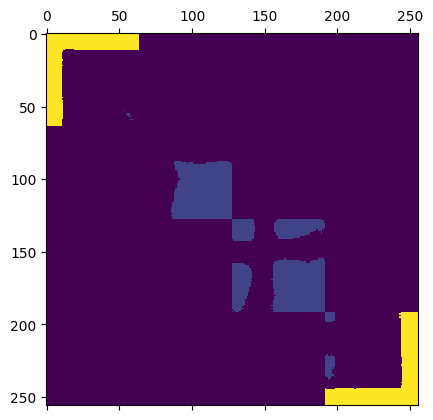

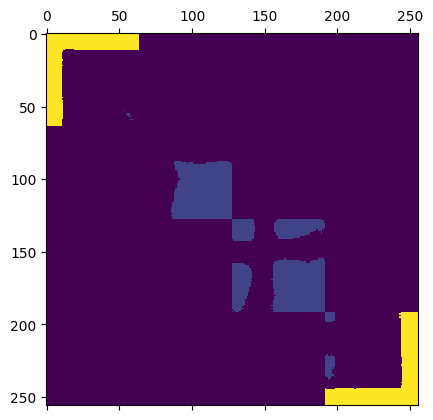

In [29]:
protein1=Protein(structure_path,chain=chain_id, filetype='pdb')
protein1.set_up()
first_residue,distance_matrix,chain_list=protein1.return_matrix_and_first_res()


#Get whole seq
for record in SeqIO.parse(structure_path, "pdb-seqres"):
    if record.annotations['chain']==chain_id:

        whole_sequence=record.seq
whole_sequence="".join([str(i) for i in whole_sequence])
#get fragments
fragments=[]
fragment=[]
seq_index_tuple=dict(zip(protein1.indices,protein1.seq_ids))
for i in range(protein1.indices[0],protein1.indices[-1]+1):
    if i in seq_index_tuple.keys():
        fragment.append(seq_index_tuple[i])
    else:
        fragments.append(fragment)
        fragment=[]
fragments.append(fragment)
sequences=["".join(fragment) for fragment in fragments]
#get start and end matches
start_iter=re.finditer(sequences[0],whole_sequence)
start=[i.span()[0] for i in start_iter][0]
end_iter=re.finditer(sequences[-1],whole_sequence)
end=[i.span()[1] for i in end_iter][0]
sequence=whole_sequence[start:end]

maxlength=protein1.indices[-1]-first_residue
prediction1=Prediction(first_res_chain=first_residue, distance_matrix_chain=distance_matrix,loaded_model=loaded_model,sub_matrix_size=128, threshold=0.90, maxlength=maxlength)
#beta,alphabeta,alpha,propeller,beta_sandwich=prediction1.get_solenoid_predictions()
beta,alphabeta,alpha=prediction1.get_solenoid_predictions()

#tot_preds, predictions, pad_value=prediction1.make_prediction()
tot_preds=prediction1.make_prediction()

print('N beta: ',len(beta))
print('N alphabeta: ',len(alphabeta))
print('N alpha: ',len(alpha))
detected_list=[beta,alphabeta,alpha]


# Visualisation

## Sequence view
The protein primary sequence is output coloured according to residue class. Residue spans are highlighted on the left-hand side.

In [24]:
aln=get_alignment(sequence)
#set up sequence viewer
p = view_alignment(aln,detected_list, plot_width=900)
display(pn.pane.Bokeh(p))


Bokeh(Column)

## Structure view with widget to pick residues
The protein structure is shown in ribbon representation with residues coloured according to solenoid class. To select equivalent positions for repeat processing click on a node in the ribbon to select the residue. To deselect the residue simply click again. The clicked residues are recorded. 

In [30]:
view=view_repeats(detected_list,structure_path)

In [31]:
out = widgets.Output(layout={'border': '2px solid red'})
picked_list=[]
def on_picked_change(b):
    with out:
        try:
            selection_up=f":{chain_id}/0 and ({b['new']['atom1']['resno']})"
            if b['new']['atom1']['resno'] in picked_list:
                #view.remove_ball_and_stick()
                picked_list.remove(b['new']['atom1']['resno'])
                selection=", ".join(map(str,picked_list))
                selection_up=f":{chain_id}/0 and ({selection})"
                view.remove_ball_and_stick()
                view.add_ball_and_stick(selection_up, color='green')
            else:
                
                print(b['new']['atom1']['resno'])
                picked_list.append(b['new']['atom1']['resno'])
                selection=", ".join(map(str,picked_list))

                selection_up=f":{chain_id}/0 and ({selection})"
                view.remove_ball_and_stick()
                view.add_ball_and_stick(selection_up, color='green')

        except:
            print()


view.observe(on_picked_change, 'picked')

In [32]:
view

NGLWidget()

In [469]:
view.download_image(filename=f'{structure_id}_{chain_id}.png', factor=16)


### Generate repeat 'reading frame' using the selected equivalent points in adjacent repeats

In [33]:
sorted_picked_list=sorted(picked_list)
top_solenoid=max(detected_list, key=len)
final_rf=[]
for i in range(len(sorted_picked_list)-1):
    repeat1=np.arange(sorted_picked_list[i],sorted_picked_list[i+1])
    repeat1=[i for i in repeat1 if i in top_solenoid]
    final_rf.append(repeat1)

### Change directory and output the results
Outputs each repeat into a separate pdb file and tars the files. The tar is then used to produce alignment files using the mTM-align server.

In [57]:
os.chdir('.')
mtmalign_results_directory=f"{structure_id}_repeats_mTM-align_results"
os.mkdir(mtmalign_results_directory)
os.chdir(mtmalign_results_directory)

#output repeats and list of repeat file names
with open(f"{structure_id}_rpt_inputs.txt","w") as f:
    for i in final_rf:


        class ResiSelect(Select):
            def accept_model(self, model):
                if model.get_id()==0:
                    return True
                else:
                    return False
            def accept_chain(self, chain):
                if chain.get_id()==chain_id:
                    return True
                else:
                    return False

            def accept_residue(self,residue):
                    if residue.get_id()[1] in i:
                        return True
                    else:
                        return False

        filename=f"{structure_id}_rpt_{final_rf.index(i)}.pdb"
        f.write(filename[:-4]+"\n")
        io=PDBIO()
        io.set_structure(protein1.structure)
        io.save(filename, ResiSelect())
#os.system(f'rm {structure_id}_rpt_inputs.txt')
os.chdir('/Users/georginikov/SOLeNNoID/jupyter_notebooks/')
#os.system(f'tar cvf test_repeat.tar {mtmalign_results_directory}')
#os.system(f'rm -r {mtmalign_results_directory}')

### View all repeats
Repeats are shown in alternating blue and red for ease of visualisation. Additional residues detected as solenoid are shown in light blue.

In [37]:
view2=view_repeats2(structure_path,final_rf)
#view2._set_camera_orientation(mat)
view2

NGLWidget()

In [457]:
view2.download_image(filename=f'{structure_id}_{chain_id}_rb_repeats.png', factor=16)


### PAIRWISE MATRIX OUTPUT

In [407]:
def get_pairwise_matrix(metric):

        assert metric=="TMscore" or metric=="rmsd", "Only TMscore and rmsd are available metrics!"

        with open(f"test_mtmalign_results_5vkq/pairwise_{metric}.txt") as f:
            repeat_pairwise_matrix=[]
            title=f.readline()
            for line in f:
                repeat_pairwise_matrix.append(np.asarray([float(i) for i in line.split()[1:]]))
        repeat_pairwise_matrix=np.asarray(repeat_pairwise_matrix)
        return repeat_pairwise_matrix

In [408]:
def show_repeat_matrix(metric):
    metric=metric
    matrix=get_pairwise_matrix(metric)
    title=f"{metric} self-similarity matrix"
    fig, ax = plt.subplots(figsize=(15,15))
    ax.matshow(matrix)
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            rmsd=round(matrix[i,j],1)
            ax.text(x=j, y=i, s=rmsd, va='center', ha='center', size='xx-large', fontsize=16)

    ax.xaxis.set_ticks_position('bottom')
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.xlabel('Repeat number', fontsize=18)
    plt.ylabel('Repeat number', fontsize=18)
    plt.title(title, fontsize=20)
    plt.savefig(f'{structure_id}_{chain_id}_TMscore.png', dpi=300)
    #plt.show()
    return

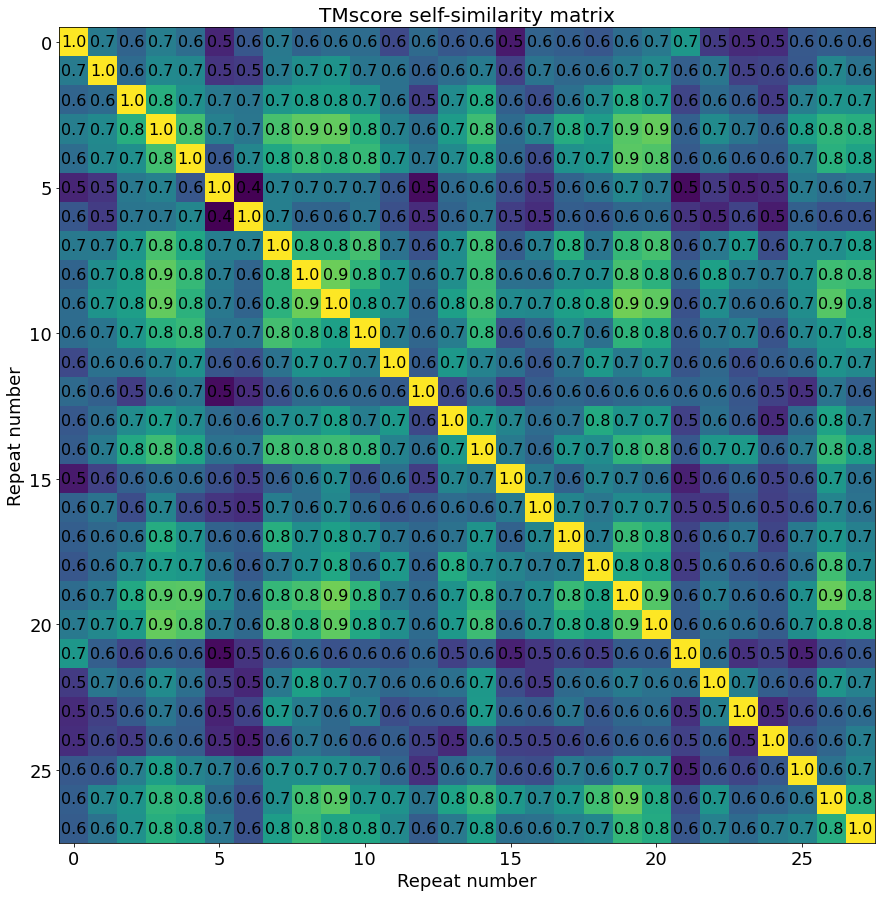

In [409]:
show_repeat_matrix('TMscore')

### Show superposed repeats - only works in line rep for some reason

In [255]:
def view_superposed_repeats():
        view=nv.show_file(f"test_mtmalign_results/new(2).pdb", default=False)
        
        #get selection to work
        #selection=", ".join(map(str, beta))
        #selection_up=f":{chain_id} and ({selection})"
        
        alphabet="ABCDEFGHIJKLMNOPQRSTUVWXYZ"
        colors=["blue", "yellow", "green", "magenta", "cyan", "orange", "purple", "lime", "pink"]*3
        #view.add_cartoon(selection="protein", color="gray", opacity=0.2)
        for i in range(len(final_rf)):
            view.add_line(selection=f":{alphabet[i]}", color=colors[i])

        #view.center(selection=selection_up)
        return view

In [256]:
view3=view_superposed_repeats()

In [257]:
view3

NGLWidget()

In [71]:
view3.download_image(filename=f'{structure_id}_{chain_id}_superposed_repeats.png', factor=16)


### Show sequence logo

In [38]:
import logomaker as lm
import pandas as pd

In [423]:
repeats_fromfasta=np.loadtxt('test_mtmalign_results_5vkq/seq.fasta', dtype='str')

In [434]:
long_sections=repeats_fromfasta[1::3]

In [435]:
short_sections=repeats_fromfasta[2::3]

In [436]:
combined_sections=[long_sections[i]+short_sections[i] for i in range(len(long_sections))]

In [437]:
combined_sections[0]

'MYATKDNKT----------A-I-MDRMIELG-A--D-------------VGARN--ND-NYN-V-------------LHI'

In [455]:
def show_repeat_sequence_logo():
    repeats_fasta_df=pd.read_csv(f'test_mtmalign_results_5vkq/seq.fasta', comment='>', header=None)
    repeats_fasta_list=repeats_fasta_df[0].values
    repeats_fasta_list=combined_sections
    '''
    try:
    '''
    #counts_mat=lm.alignment_to_matrix(sequences=repeats_fasta_list, to_type='counts', characters_to_ignore='-')
    counts_mat=lm.alignment_to_matrix(sequences=repeats_fasta_list, to_type='counts')

    counts_mat.head()
    '''
    except:
        repeats=[]
        with open (f'{mtmalign_results_directory}/result.fasta') as file:
            data=file.readlines()
            for i,line in enumerate(data):
                if line.startswith(">")==False:
                      repeats.append(line.rstrip())
        connected_repeats=[]
        for i in range(len(repeats[0::2])):
            connected=repeats[0::2][i]+repeats[1::2][i]
            connected_repeats.append(connected)    
        counts_mat=lm.alignment_to_matrix(sequences=connected_repeats, to_type='counts', characters_to_ignore='-')
        counts_mat.head()
    '''
    logo=lm.Logo(counts_mat, color_scheme='weblogo_protein', figsize=(8,2))

    #logo.highlight_position_range(6,6,alpha=0.3,color='blue')
    #logo.highlight_position_range(11,11,alpha=0.3,color='blue')
    #logo.highlight_position_range(17,17,alpha=0.3,color='blue')

    
    
    logo.highlight_position_range(0,8,alpha=0.3,color='magenta')
    logo.highlight_position_range(21,21,alpha=0.3,color='magenta')
    logo.highlight_position_range(23,30,alpha=0.3,color='magenta')
    logo.highlight_position_range(56,57,alpha=0.3,color='magenta')
    logo.highlight_position_range(59,60,alpha=0.3,color='magenta')
    logo.highlight_position_range(79,79,alpha=0.3,color='magenta')

    '''
    logo.highlight_position_range(18,31,alpha=0.3,color='blue')
    logo.highlight_position_range(36,36,alpha=0.3,color='blue')
    '''

    #logo.style_xticks(spacing=2, anchor=len(repeats_fasta_list[0]), fmt='%d', fontsize=5)
    #logo.style_yticks(spacing=2, anchor=len(repeats_fasta_list[0]), fmt='%d', fontsize=50)

    logo.ax.set_xlabel('Position', fontsize=8)
    logo.ax.set_title('Sequence logo', fontsize=8)
    logo.ax.set_xticks([0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80])
    #logo.ax.set_yticks([i for i in range(len(final_rf))])
    logo.ax.set_ylabel('Counts', fontsize=8)
    plt.savefig(f'{structure_id}_{chain_id}_seqlogo.png',dpi=300, bbox_inches='tight')
    return

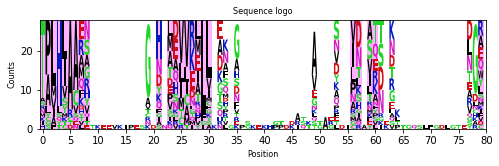

In [456]:
show_repeat_sequence_logo()